# 1. Importing libraries

In [70]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest


import eda_helper_functions

warnings.filterwarnings('ignore')

# 2. Reading training set

In [2]:
file_path = "/home/pratik/Desktop/flight_price_sagemaker/data/train.csv"
train = pd.read_csv(file_path)
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-09,Delhi,Cochin,00:20:00,07:40:00,440,1.0,In-flight meal not included,13977
1,Jet Airways,2019-05-24,Kolkata,Banglore,20:25:00,09:45:00,800,1.0,In-flight meal not included,12384
2,Jet Airways,2019-05-09,Delhi,Cochin,18:15:00,04:25:00,610,1.0,In-flight meal not included,12373
3,Multiple Carriers,2019-06-01,Delhi,Cochin,10:00:00,01:30:00,930,1.0,No info,7198
4,Jet Airways,2019-06-01,Delhi,Cochin,21:50:00,12:35:00,885,1.0,In-flight meal not included,10262


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col])
    for col in ['date_of_journey', 'dep_time', 'arrival_time']
})

In [5]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

 ### Summary of data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      639 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [7]:
train[train['total_stops'].isna()]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
434,Air India,2019-05-06,Delhi,Cochin,2024-05-31 09:45:00,2024-05-31 09:25:00,1420,NaN,No info,7480


In [8]:
train = train.drop(index=[434])

In [9]:
train.describe(include='number')

,duration,total_stops,price
count,639.000000,639.000000,639.000000
mean,660.688576,0.848200,9228.497653
std,501.640486,0.655667,4912.005071
min,75.000000,0.000000,1759.000000
25%,175.000000,0.000000,5196.500000
50%,540.000000,1.000000,8529.000000
75%,957.500000,1.000000,12395.000000
max,2295.000000,4.000000,52229.000000


In [10]:
(
    train
    .assign(total_stops=train['total_stops'].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,639,639,639,639.0,639
unique,8,5,6,5.0,5
top,Jet Airways,Delhi,Cochin,1.0,No info
freq,232,262,262,367.0,493


### Analysis of missing values

In [11]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


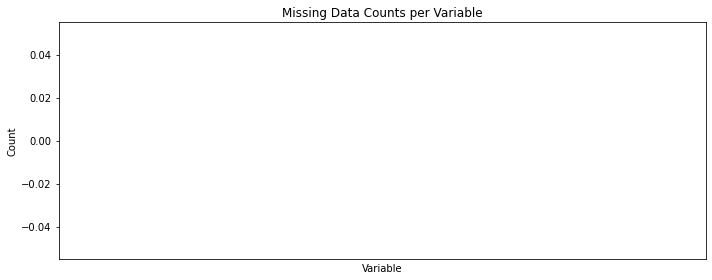

In [12]:
eda_helper_functions.plot_missing_info(train)

In [13]:
# library for missing value --> missingno
# for outliers --> isolation forest

### Analysis for Outliers

In [14]:
forest = IsolationForest()

In [15]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
    # query is used to filter the data
    .query("outlier == -1")
    .describe()
)

,date_of_journey,dep_time,arrival_time,duration,total_stops,price,outlier
count,245,245,245,245.000000,245.000000,245.000000,245.0
mean,2019-05-04 07:56:04.897959168,2024-05-31 12:30:48.979591680,2024-05-31 13:17:19.591836672,951.653061,1.106122,9598.053061,-1.0
min,2019-03-01 00:00:00,2024-05-31 02:30:00,2024-05-31 00:10:00,75.000000,0.000000,1759.000000,-1.0
25%,2019-03-27 00:00:00,2024-05-31 08:00:00,2024-05-31 08:15:00,195.000000,0.000000,5177.000000,-1.0
50%,2019-05-15 00:00:00,2024-05-31 11:50:00,2024-05-31 12:35:00,1165.000000,1.000000,9663.000000,-1.0
75%,2019-06-06 00:00:00,2024-05-31 17:00:00,2024-05-31 19:15:00,1470.000000,2.000000,12854.000000,-1.0
max,2019-06-27 00:00:00,2024-05-31 23:05:00,2024-05-31 23:45:00,2295.000000,4.000000,26890.000000,-1.0
std,NaN,NaN,NaN,632.544483,0.817936,4652.620154,0.0


### 6. Pair Plots

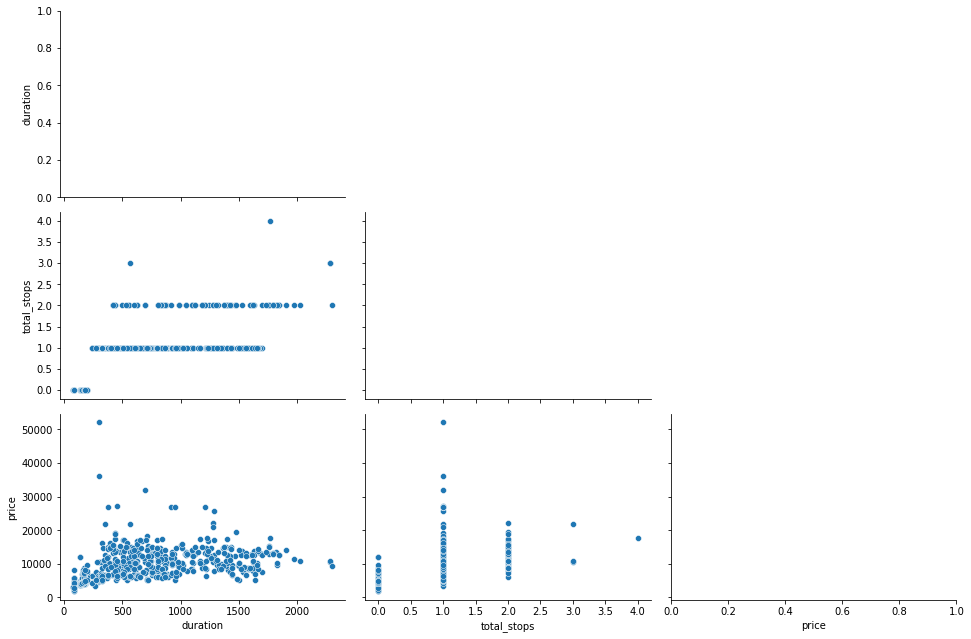

In [16]:
eda_helper_functions.pair_plots(train)

### 7. Correlation Analysis

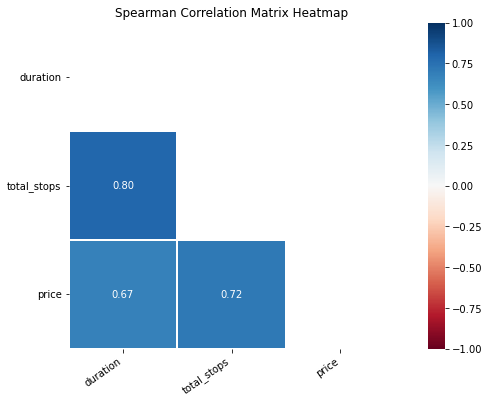

In [17]:
eda_helper_functions.correlation_heatmap(train)

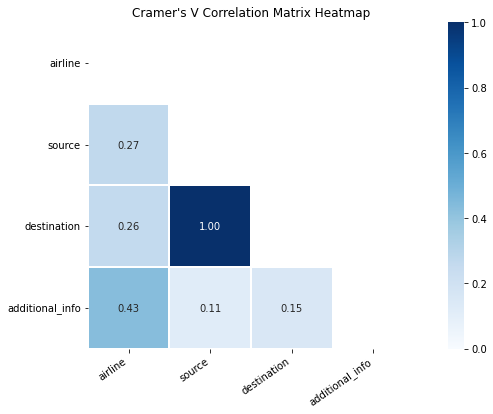

In [18]:
eda_helper_functions.cramersV_heatmap(train)

# 8. Detailed Analysis

### 8.1 Airline

In [19]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

In [22]:
train.airline

0      Multiple Carriers
1            Jet Airways
2            Jet Airways
3      Multiple Carriers
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639          Jet Airways
Name: airline, Length: 639, dtype: object

In [23]:
eda_helper_functions.cat_summary(train, "airline")

0      Multiple Carriers
1            Jet Airways
2            Jet Airways
3      Multiple Carriers
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639          Jet Airways
Name: airline, Length: 639, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 639 / 639 rows


,
count,639
unique,8
top,Jet Airways
freq,232


,count,percentage
category,,
Jet Airways,232,0.363067
Indigo,136,0.212833
Air India,103,0.161189
Multiple Carriers,71,0.111111
Spicejet,43,0.067293
Air Asia,22,0.034429
Vistara,20,0.031299
Goair,12,0.018779


In [35]:
train.airline.value_counts()

airline
Jet Airways          232
Indigo               136
Air India            103
Multiple Carriers     71
Spicejet              43
Air Asia              22
Vistara               20
Goair                 12
Name: count, dtype: int64

In [36]:
train.airline.value_counts(normalize = True)

airline
Jet Airways          0.363067
Indigo               0.212833
Air India            0.161189
Multiple Carriers    0.111111
Spicejet             0.067293
Air Asia             0.034429
Vistara              0.031299
Goair                0.018779
Name: proportion, dtype: float64

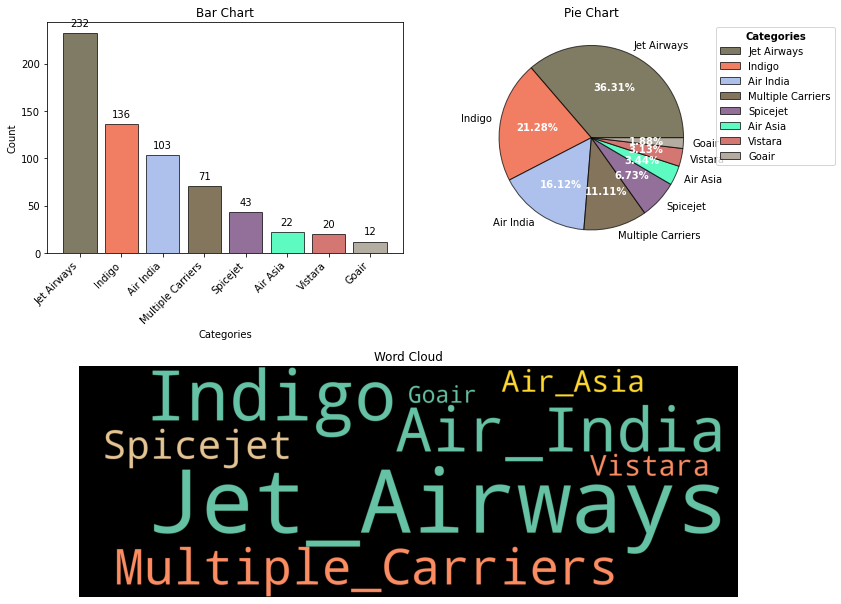

In [37]:
eda_helper_functions.cat_univar_plots(train, 'airline')

- Wordcloud to be used when we have high cardinality (many categories)

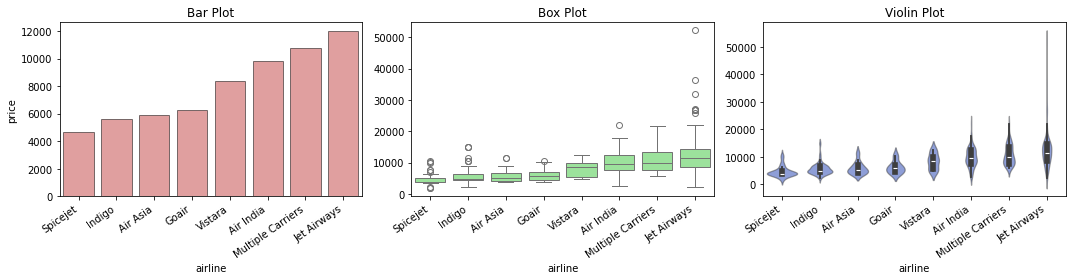

In [39]:
eda_helper_functions.num_cat_bivar_plots(data=train, 
                                         num_var='price',
                                        cat_var='airline')

In [40]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 43.78079722764165
- p-value              : 1.9161141282336822e-50
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 282.09883091409245
- p-value              : 4.004792864866303e-57
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


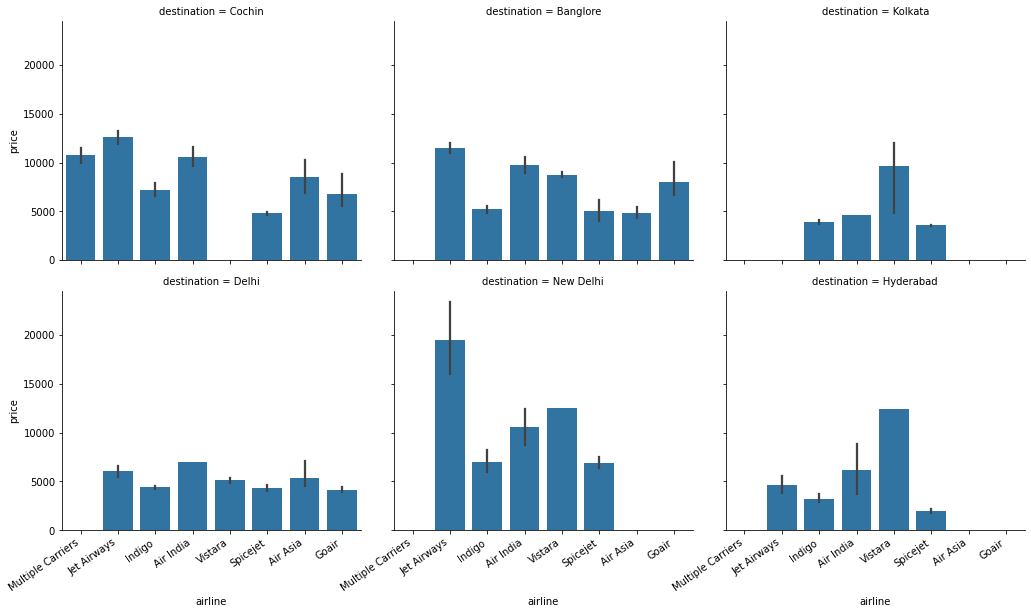

In [47]:
airline_grid = sns.FacetGrid(
    data = train,
    col = 'destination',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey = True
)

airline_grid.map(sns.barplot, 'airline', 'price', order=train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

### Date_of_Journey

In [48]:
train.date_of_journey

0     2019-03-09
1     2019-05-24
2     2019-05-09
3     2019-06-01
4     2019-06-01
         ...    
635   2019-03-15
636   2019-06-15
637   2019-06-12
638   2019-05-18
639   2019-05-18
Name: date_of_journey, Length: 639, dtype: datetime64[ns]

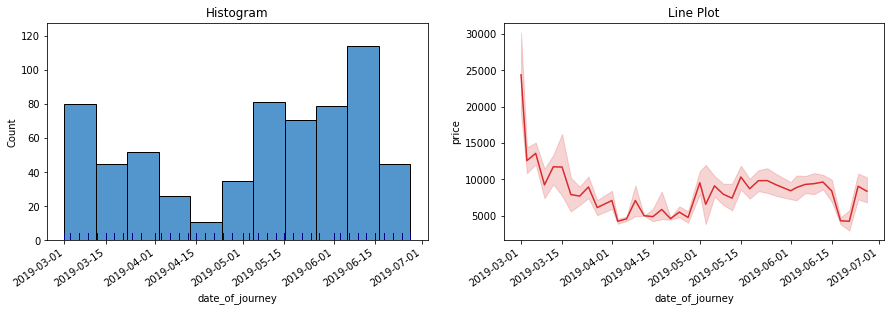

In [50]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var='date_of_journey',
    target='price'
)

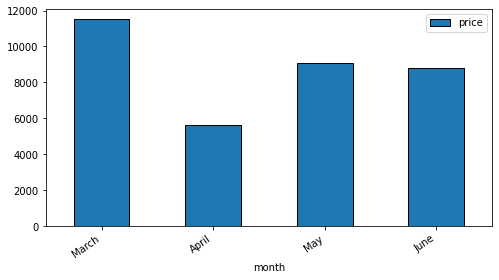

In [74]:
(
    train
    .groupby(pd.Grouper(key='date_of_journey', freq='M'))['price']
    .mean()
    .to_frame()
    .set_axis(['March', 'April', 'May', 'June'], axis=0)
    .rename_axis(index='month')
    .plot(
        kind='bar',
        figsize=(8, 4),
        edgecolor='black'
    )
)

# gca = get current axis
ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

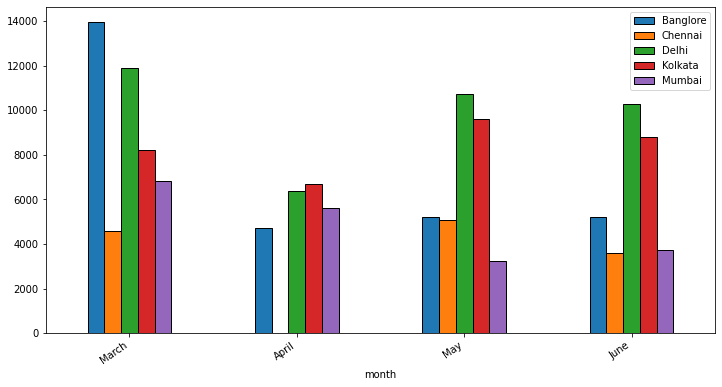

In [98]:
(
    train
    .groupby([pd.Grouper(key='date_of_journey', freq='M'), 'source'])['price']
    .mean()
    .unstack(fill_value=0)
    .set_axis(['March', 'April', 'May', 'June'], axis=0)
    .rename_axis(index='month')
    .plot(
        kind='bar',
        figsize=(12, 6),
        edgecolor='black'
    )
)

ax = plt.gca()
ax.legend(
    loc='upper right',
    bbox_to_anchor=(1, 1)
)
eda_helper_functions.rotate_xlabels(ax)

### 8.3 Dep_Time

In [99]:
train.dep_time

0     2024-05-31 00:20:00
1     2024-05-31 20:25:00
2     2024-05-31 18:15:00
3     2024-05-31 10:00:00
4     2024-05-31 21:50:00
              ...        
635   2024-05-31 11:40:00
636   2024-05-31 09:35:00
637   2024-05-31 04:55:00
638   2024-05-31 05:45:00
639   2024-05-31 05:30:00
Name: dep_time, Length: 639, dtype: datetime64[ns]

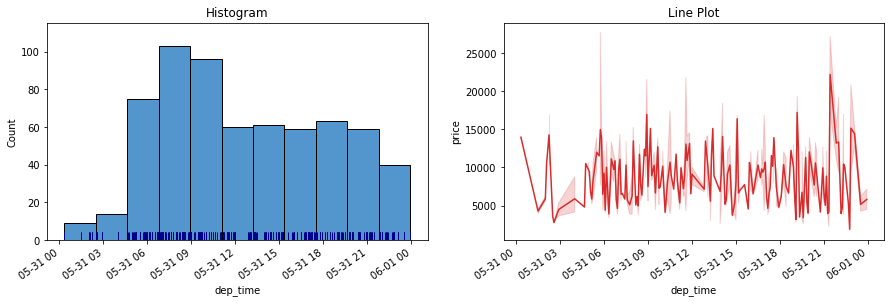

In [100]:
eda_helper_functions.dt_univar_plots(train, 'dep_time', 'price')

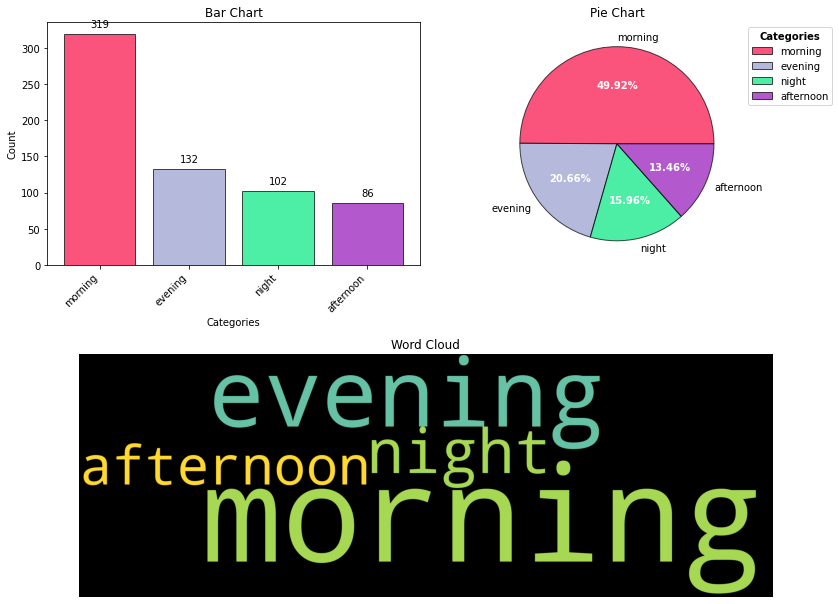

In [114]:
# Converting hours info to part of a day --> morning, evening, night
# assign is used to create a new column or update a new column
(
    
    train
    .assign(dep_time=lambda df_ : (
      np.select([df_.dep_time.dt.hour.between(4, 12, inclusive='left'),
                 df_.dep_time.dt.hour.between(12, 16, inclusive='left'),
                 df_.dep_time.dt.hour.between(16, 20, inclusive='left')], 
                ['morning', 'afternoon', 'evening'], 
                 default='night')))
    .pipe(eda_helper_functions.cat_univar_plots, 'dep_time')
    
)

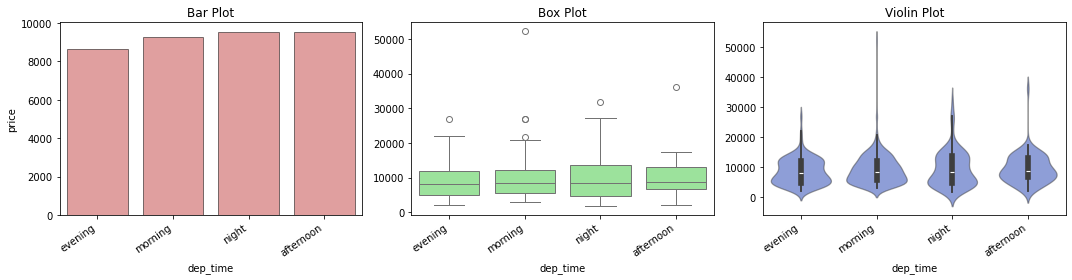

In [115]:
# Converting hours info to part of a day --> morning, evening, night
# assign is used to create a new column or update a new column
(
    
    train
    .assign(dep_time=lambda df_ : (
      np.select([df_.dep_time.dt.hour.between(4, 12, inclusive='left'),
                 df_.dep_time.dt.hour.between(12, 16, inclusive='left'),
                 df_.dep_time.dt.hour.between(16, 20, inclusive='left')], 
                ['morning', 'afternoon', 'evening'], 
                 default='night')))
    .pipe(eda_helper_functions.num_cat_bivar_plots, 'price', 'dep_time')
    
)

### 8.4 Duration

In [116]:
train.duration

0       440
1       800
2       610
3       930
4       885
       ... 
635     405
636    1620
637     460
638    1655
639     425
Name: duration, Length: 639, dtype: int64

In [117]:
eda_helper_functions.num_summary(train, 'duration')

0       440
1       800
2       610
3       930
4       885
       ... 
635     405
636    1620
637     460
638    1655
639     425
Name: duration, Length: 639, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 639 / 639 rows


,value
percentile,
0,75.0
5,135.0
10,150.0
25,175.0
50,540.0
75,957.5
90,1440.0
95,1625.5
99,1840.0


,value
mean,660.688576
trimmed mean (5%),629.956672
trimmed mean (10%),602.884990
median,540.000000


,value
var,251643.177158
std,501.640486
IQR,782.500000
mad,365.000000
coef_variance,0.759269


,value
skewness,0.823493
kurtosis,-0.242477


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 5.902232101411331e-20
Test Statistic       : 0.900454195525221
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 20.120658737645044
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


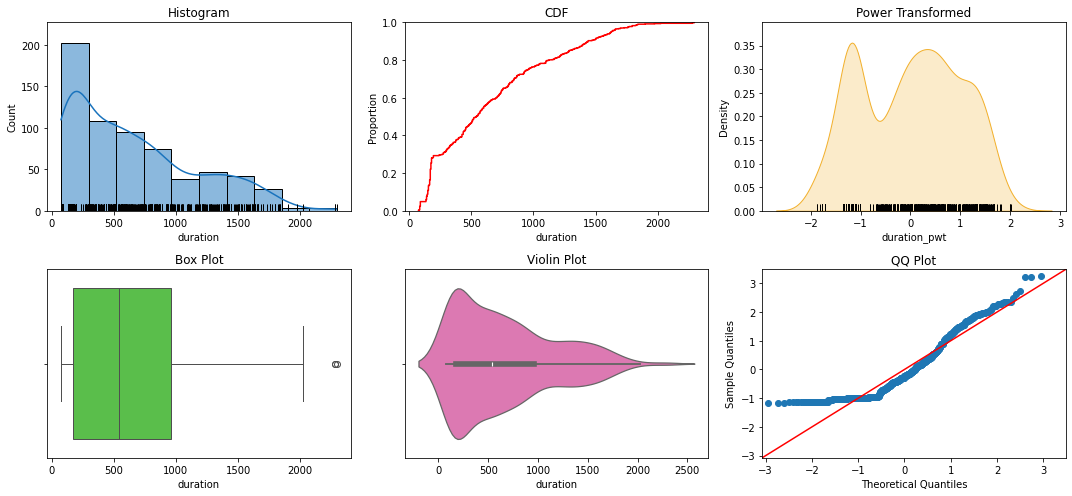

In [118]:
eda_helper_functions.num_univar_plots(train, 'duration')

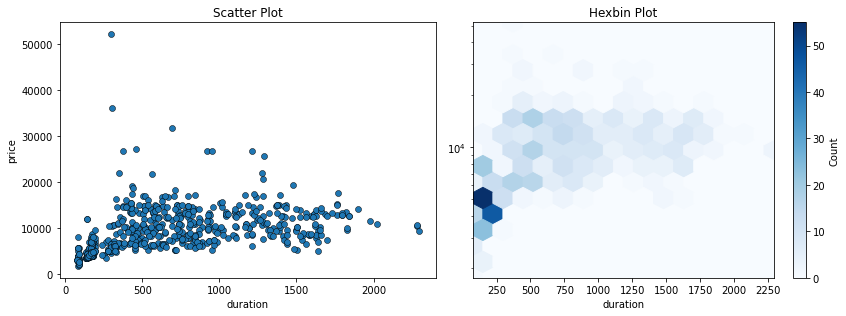

In [122]:
eda_helper_functions.num_bivar_plots(
    train, 
    'duration',
    'price',
    hexbin_kwargs=dict(
        yscale='log',
        gridsize=15,
        cmap='Blues'
    )
)

In [123]:
eda_helper_functions.num_num_hyp_testing(train, 'duration', 'price')

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.44187785215832515
- p-value              : 6.362480430700294e-32
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6730974840504247
- p-value              : 1.601544316337271e-85
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


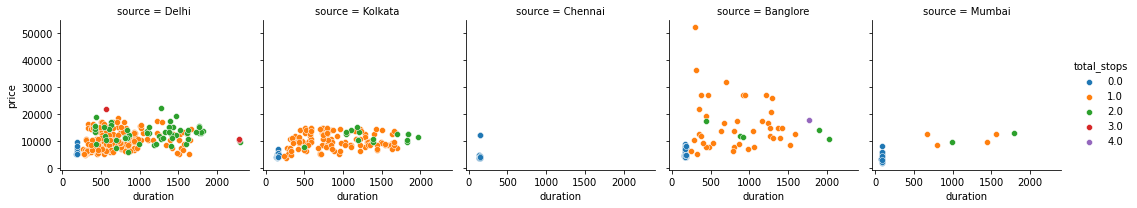

In [126]:
duration_grid = sns.FacetGrid(
    data=train,
    col='source',
    hue='total_stops',
    sharey=True
)
duration_grid.map(sns.scatterplot, 'duration', 'price')
duration_grid.add_legend()

In [131]:
eda_helper_functions.get_iqr_outliers(train, 'duration')

Lower Limit : -998.75
Upper Limit : 2131.25


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
171,Air India,2019-06-03,Delhi,Cochin,2024-05-31 05:15:00,2024-05-31 19:15:00,2280,3.0,No info,10493
317,Air India,2019-06-06,Delhi,Cochin,2024-05-31 05:15:00,2024-05-31 19:15:00,2280,3.0,No info,10703
321,Air India,2019-06-12,Delhi,Cochin,2024-05-31 05:00:00,2024-05-31 19:15:00,2295,2.0,No info,9443


### 9. Automated EDA
- ydata profiling
- dtale
- sweetviz

In [128]:
from ydata_profiling import ProfileReport

In [129]:
report = ProfileReport(train)

In [130]:
report.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]